#Competitive Market Analysis by Country

##SETUP

In [2]:
! pip install pyspark -q

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import functions as fn

sc = SparkContext.getOrCreate()

spark = SparkSession\
    .builder\
    .appName('Meowdarchod')\
    .getOrCreate()

In [4]:
df = spark.read.csv("DataCoSupplyChainDataset.csv", header=True, inferSchema=True)

In [5]:
df.show(5)

+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per c

In [6]:
pip install unidecode

In [7]:
import unidecode

# Get unique 'Order Country' values using PySpark functions
spanish_countries = df.select("Order Country").distinct().dropna().rdd.flatMap(lambda x: x).collect()
spanish_countries = sorted(spanish_countries)

# Helper: Normalize encoding (remove accents, fix broken characters)
normalized = [unidecode.unidecode(x) for x in spanish_countries]

# Manual + auto-translations (update as needed)
translation_map = {
    "Estados Unidos": "United States",
    "Luxemburgo": "Luxemberg",
    "Japon": "Japan",
    "Republica Dominicana": "Dominican Republic",
    "Emiratos Arabes Unidos": "United Arab Emirates",
    "Sahara Occidental": "Western Sahara",
    "Corea del Sur": "South Korea",
    "Corea del Norte": "North Korea",
    "Egipto": "Egypt",
    "India": "India",
    "China": "China",
    "Espana": "Spain",
    "Francia": "France",
    "Alemania": "Germany",
    "Italia": "Italy",
    "Mexico": "Mexico",
    "Brasil": "Brazil",
    "Argentina": "Argentina",
    "Canada": "Canada",
    "Sudafrica": "South Africa",
    # fallback to normalized
}

# Final translation: use map or default to normalized name
english_translations = [translation_map.get(unidecode.unidecode(x), unidecode.unidecode(x)) for x in spanish_countries]

# Create a DataFrame with original + translated names
import pandas as pd  # Make sure pandas is imported
df_translated = pd.DataFrame({
    "Order Country (Spanish)": spanish_countries,
    "Order Country (English)": english_translations
})

In [8]:
# drop Order Country column in df and add Order Country (English) from df_translated to df

# Create a Spark DataFrame from the pandas DataFrame
df_translated_spark = spark.createDataFrame(df_translated)

# Join the original DataFrame with the translated DataFrame
df = df.join(df_translated_spark, df["Order Country"] == df_translated_spark["Order Country (Spanish)"], "left")

# Drop the original "Order Country" column
df = df.drop("Order Country")

# Rename the translated column
df = df.withColumnRenamed("Order Country (English)", "Order Country")

# Show the updated DataFrame
df.show(5)


+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+------------+-----------+---------------+-------------+---------------+-------------------+-------------------+--------------------+--------------------+-------------+--------------+--------------------------+--------------+-----------------------+-------------+
|    Type|Days for shipping (real)|Days for shipment (sched

In [9]:
df.columns

['Type',
 'Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Benefit per order',
 'Sales per customer',
 'Delivery Status',
 'Late_delivery_risk',
 'Category Id',
 'Category Name',
 'Customer City',
 'Customer Country',
 'Customer Email',
 'Customer Fname',
 'Customer Id',
 'Customer Lname',
 'Customer Password',
 'Customer Segment',
 'Customer State',
 'Customer Street',
 'Customer Zipcode',
 'Department Id',
 'Department Name',
 'Latitude',
 'Longitude',
 'Market',
 'Order City',
 'Order Customer Id',
 'order date (DateOrders)',
 'Order Id',
 'Order Item Cardprod Id',
 'Order Item Discount',
 'Order Item Discount Rate',
 'Order Item Id',
 'Order Item Product Price',
 'Order Item Profit Ratio',
 'Order Item Quantity',
 'Sales',
 'Order Item Total',
 'Order Profit Per Order',
 'Order Region',
 'Order State',
 'Order Status',
 'Order Zipcode',
 'Product Card Id',
 'Product Category Id',
 'Product Description',
 'Product Image',
 'Product Name',
 'Product Price',
 'Product S

In [10]:
df.count()

180519

In [11]:
#needed columns
selected_cols = [
    "Order Country",
    "Order Id",
    "Category Name",
    "Order Item Quantity",
    "Order Item Product Price",
    "Order Item Discount",
    "Order Item Discount Rate",
    "Order Item Total",
    "Sales",
    "Product Price",
    "Order Profit Per Order",
    'Order Region',
    'Order State',
    "order date (DateOrders)"
]

df1 = df.select(*selected_cols)
df1.show(5)


+-------------+--------+--------------+-------------------+------------------------+-------------------+------------------------+----------------+-----------+-------------+----------------------+------------+-----------+-----------------------+
|Order Country|Order Id| Category Name|Order Item Quantity|Order Item Product Price|Order Item Discount|Order Item Discount Rate|Order Item Total|      Sales|Product Price|Order Profit Per Order|Order Region|Order State|order date (DateOrders)|
+-------------+--------+--------------+-------------------+------------------------+-------------------+------------------------+----------------+-----------+-------------+----------------------+------------+-----------+-----------------------+
|    Australia|   75937|Sporting Goods|                  1|                  327.75|        22.94000053|                    0.07|     304.8099976|     327.75|       327.75|           22.86000061|     Oceania| Queensland|        1/13/2018 11:45|
|    Australia|   75

null values

In [12]:
from pyspark.sql.functions import col, when, count, isnan

# Count nulls in each column
df1.select([count(when(col(c).isNull(), c)).alias(c) for c in df1.columns]).show()

df1.select([
    count(
        when(
            col(c).isNull() | isnan(col(c)) | (col(c) == ""), c
        )
    ).alias(c)
    for c in df1.columns
]).show()



+-------------+--------+-------------+-------------------+------------------------+-------------------+------------------------+----------------+-----+-------------+----------------------+------------+-----------+-----------------------+
|Order Country|Order Id|Category Name|Order Item Quantity|Order Item Product Price|Order Item Discount|Order Item Discount Rate|Order Item Total|Sales|Product Price|Order Profit Per Order|Order Region|Order State|order date (DateOrders)|
+-------------+--------+-------------+-------------------+------------------------+-------------------+------------------------+----------------+-----+-------------+----------------------+------------+-----------+-----------------------+
|            0|       0|            0|                  0|                       0|                  0|                       0|               0|    0|            0|                     0|           0|          0|                      0|
+-------------+--------+-------------+----------

In [13]:
df1.columns

['Order Country',
 'Order Id',
 'Category Name',
 'Order Item Quantity',
 'Order Item Product Price',
 'Order Item Discount',
 'Order Item Discount Rate',
 'Order Item Total',
 'Sales',
 'Product Price',
 'Order Profit Per Order',
 'Order Region',
 'Order State',
 'order date (DateOrders)']

In [14]:
from pyspark.sql.types import *

# Define a function to determine column data type
def get_column_type(df1, column_name):
    for field in df1.schema.fields:
        if field.name == column_name:
            return field.dataType
    return None

# Separate numerical and categorical columns
numerical_cols = []
categorical_cols = []
for column_name in df1.columns:  # Use df1 instead of df_cleaned
    column_type = get_column_type(df1, column_name)
    if column_type in (IntegerType(), LongType(), FloatType(), DoubleType()):
        numerical_cols.append(column_name)
    elif column_type == StringType():
        categorical_cols.append(column_name)
    else:
        print(f"Column '{column_name}' has an unsupported data type: {column_type}")

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)


Numerical Columns: ['Order Id', 'Order Item Quantity', 'Order Item Product Price', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Total', 'Sales', 'Product Price', 'Order Profit Per Order']
Categorical Columns: ['Order Country', 'Category Name', 'Order Region', 'Order State', 'order date (DateOrders)']


In [15]:
df_numerical = df1.select(numerical_cols)
df_categorical = df1.select(categorical_cols)

df_numerical.show(5)
df_categorical.show(5)


+--------+-------------------+------------------------+-------------------+------------------------+----------------+-----------+-------------+----------------------+
|Order Id|Order Item Quantity|Order Item Product Price|Order Item Discount|Order Item Discount Rate|Order Item Total|      Sales|Product Price|Order Profit Per Order|
+--------+-------------------+------------------------+-------------------+------------------------+----------------+-----------+-------------+----------------------+
|   75937|                  1|                  327.75|        22.94000053|                    0.07|     304.8099976|     327.75|       327.75|           22.86000061|
|   75936|                  1|                  327.75|               29.5|             0.090000004|          298.25|     327.75|       327.75|           134.2100067|
|   75935|                  1|                  327.75|        32.77999878|             0.100000001|      294.980011|     327.75|       327.75|           18.57999992

In [16]:
from pyspark.sql.functions import col, when
from functools import reduce

country_map = {
    'Repblica Centroafricana': 'Central African Republic',
    'Azerbaiyn': 'Azerbaijan',
    'Suiza': 'Switzerland',
    'Repblica Democrtica del Congo': 'Democratic Republic of the Congo',
    'Kenia': 'Kenya',
    'Nueva Zelanda': 'New Zealand',
    'Croacia': 'Croatia',
    'Japn': 'Japan',
    'Taiwn': 'Taiwan',
    'Lesoto': 'Lesotho',
    'Omn': 'Oman',
    'Uzbekistn': 'Uzbekistan',
    'Arabia Saud': 'Saudi Arabia',
    'Camern': 'Cameroon',
    'Afganistn': 'Afghanistan',
    'Filipinas': 'Philippines',
    'Guadalupe': 'Guadeloupe',
    'Sudn': 'Sudan',
    'Jordania': 'Jordan',
    'Finlandia': 'Finland',
    'Eslovaquia': 'Slovakia',
    'Zimbabue': 'Zimbabwe',
    'Emiratos rabes Unidos': 'United Arab Emirates',
    'SudAfrica': 'South Africa',
    'Siria': 'Syria',
    'Butn': 'Bhutan',
    'Botsuana': 'Botswana',
    'Ruanda': 'Rwanda',
    'Chipre': 'Cyprus',
    'Benn': 'Benin',
    'Papa Nueva Guinea': 'Papua New Guinea',
    'Eslovenia': 'Slovenia',
    'Rusia': 'Russia',
    'Belice': 'Belize',
    'Irak': 'Iraq',
    'Suazilandia': 'Eswatini',
    'Rumania': 'Romania',
    'Kazajistn': 'Kazakhstan',
    'Lbano': 'Lebanon',
    'Guayana Francesa': 'French Guiana',
    'Barin': 'Bahrain',
    'Hungra': 'Hungary',
    'Bielorrusia': 'Belarus',
    'Per': 'Peru',
    'Grecia': 'Greece',
    'Tailandia': 'Thailand',
    'Martinica': 'Martinique',
    'Gabn': 'Gabon',
    'Sudn del Sur': 'South Sudan',
    'Pakistn': 'Pakistan',
    'Repblica de Gambia': 'The Gambia',
    'Kirguistn': 'Kyrgyzstan',
    'Shara Occidental': 'Western Sahara',
    'Repblica Checa': 'Czech Republic',
    'Sierra Leona': 'Sierra Leone',
    'Lituania': 'Lithuania',
    'Repblica Dominicana': 'Dominican Republic',
    'Pases Bajos': 'Netherlands',
    'Panam': 'Panama',
    'Hait': 'Haiti',
    'Singapur': 'Singapore',
    'Yibuti': 'Djibouti',
    'Luxemberg': 'Luxembourg',
    'Tayikistn': 'Tajikistan',
    'Irn': 'Iran',
    'Myanmar (Birmania)': 'Myanmar',
    'Banglads': 'Bangladesh',
    'Mxico': 'Mexico',
    'Macedonia': 'North Macedonia',
    'Etiopa': 'Ethiopia',
    'Tnez': 'Tunisia',
    'Espaa': 'Spain',
    'Dinamarca': 'Denmark',
    'Repblica del Congo': 'Republic of the Congo',
    'Irlanda': 'Ireland',
    'Noruega': 'Norway',
    'Reino Unido': 'United Kingdom',
    'Guinea-Bissau': 'Guinea-Bissau',
    'Camboya': 'Cambodia',
    'Blgica': 'Belgium',
    'Nger': 'Niger',
    'Marruecos': 'Morocco',
    'Polonia': 'Poland',
    'Turqua': 'Turkey',
    'Moldavia': 'Moldova',
    'Libia': 'Libya',
    'Malasia': 'Malaysia',
    'Argelia': 'Algeria',
    'Suecia': 'Sweden',
    'Ucrania': 'Ukraine'
}


# Create a column update expression using 'when'
order_country_col = reduce(
    lambda col_expr, kv: col_expr.when(col("Order Country") == kv[0], kv[1]),
    country_map.items(),
    when(col("Order Country") == "___", "___")
)

# Finalize with .otherwise() to keep unchanged values
order_country_col = order_country_col.otherwise(col("Order Country"))

# Replace column in DataFrame
df1 = df1.withColumn("Order Country", order_country_col)

# Confirm updated values
df1.select("Order Country").distinct().show(50, truncate=False)

+-----------------+
|Order Country    |
+-----------------+
|Chad             |
|Paraguay         |
|Russia           |
|Yemen            |
|Senegal          |
|Costa de Marfil  |
|Sweden           |
|Guyana           |
|Eritrea          |
|Surinam          |
|Philippines      |
|Djibouti         |
|Singapore        |
|Malaysia         |
|Turkey           |
|Western Sahara   |
|Iraq             |
|Germany          |
|Guinea Ecuatorial|
|Afghanistan      |
|Cambodia         |
|Jordan           |
|Rwanda           |
|Sudan            |
|France           |
|Greece           |
|Sri Lanka        |
|Taiwan           |
|Togo             |
|Algeria          |
|Slovakia         |
|Argentina        |
|Angola           |
|Belgium          |
|Ecuador          |
|Qatar            |
|Lesotho          |
|Madagascar       |
|Albania          |
|Finland          |
|Nicaragua        |
|Ghana            |
|Myanmar          |
|The Gambia       |
|Benin            |
|Sierra Leone     |
|Peru             |


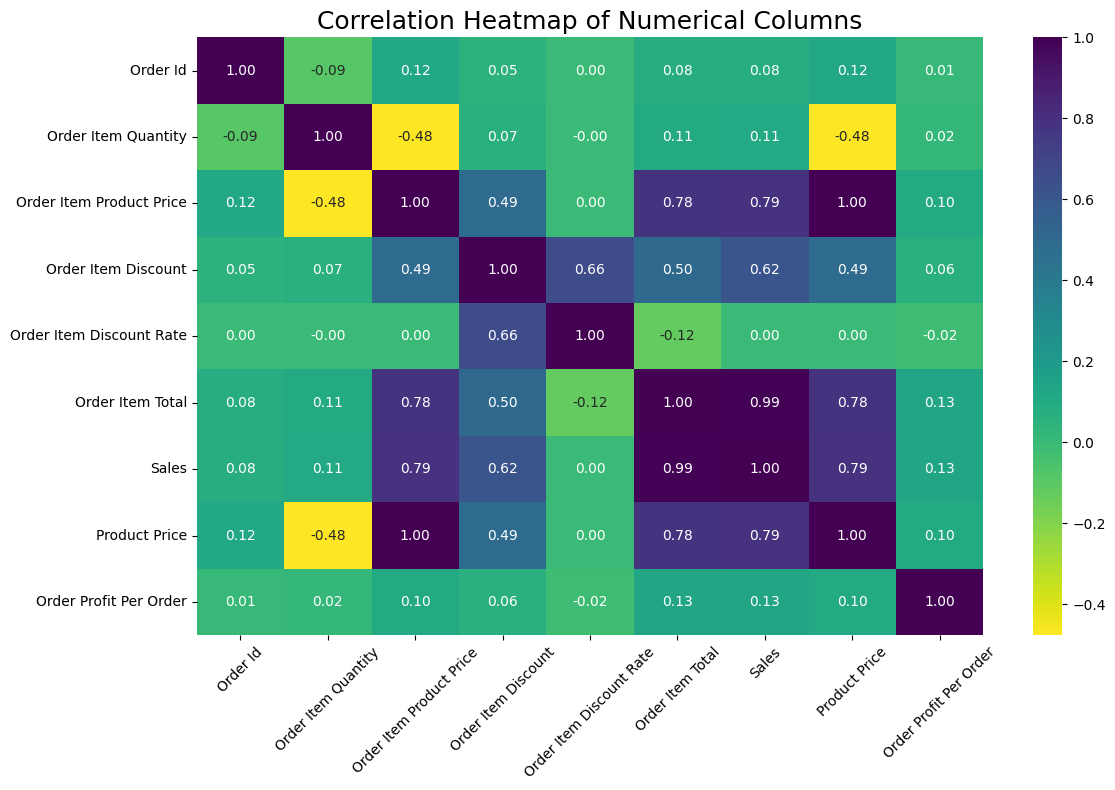

In [17]:
# Convert PySpark DataFrame to Pandas
df_numerical_pd = df_numerical.toPandas()

# Calculate correlation matrix
correlation_matrix = df_numerical_pd.corr()

# Plot the heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis_r', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Columns", fontsize=18)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [18]:
# Convert PySpark DataFrame to Pandas
df_categorical_pd = df_categorical.toPandas()

# function for counting the categorical variables on X axis
plt.rcParams["figure.figsize"] = 11,6
def categ_count_x(categ_var, title):
    # Access the column using the correct name 'Delivery Status'
    # Check if the column exists in the DataFrame before plotting
    if categ_var in df_categorical_pd.columns:
        sb.countplot(data = df_categorical_pd , x = df_categorical_pd[categ_var],order= df_categorical_pd[categ_var].value_counts().index, palette='gist_heat')
        plt.title(title, size = 20)
        plt.show()

import seaborn as sb
# Call the function with the correct column name 'Delivery Status'
categ_count_x("Type","Type of transaction made")
categ_count_x("Delivery Status","Delivery status of orders")
categ_count_x("Customer Country","City where the customer made the purchase")

#Flow of the orders from Customer's Country to the Regions of the world where are delivered

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
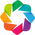

In [19]:
!pip install holoviews
import holoviews as hv
!pip install holoviews bokeh
from holoviews import opts
hv.extension('bokeh') # Load the Bokeh extension

In [20]:
from pyspark.sql.functions import countDistinct

# Step 2: Group by country and region, count orders
df_unique_orders_flow = (
    df # Changed from df1 to df
    .groupBy("Order Country", "Order Region")
    .agg(countDistinct("Order Id").alias("the_count_of_unique_orders"))
)

# Step 3: Show the result
df_unique_orders_flow.show()

+--------------------+---------------+--------------------------+
|       Order Country|   Order Region|the_count_of_unique_orders|
+--------------------+---------------+--------------------------+
|              Angola| Central Africa|                       103|
|           Tailandia| Southeast Asia|                       403|
| Repblica Dominicana|      Caribbean|                      1242|
|                Hait|      Caribbean|                       174|
|Bosnia y Herzegovina|Southern Europe|                        16|
|               China|   Eastern Asia|                      2616|
|            Lituania|Northern Europe|                        41|
|               India|     South Asia|                      2152|
|              Belice|Central America|                         4|
|               Egypt|   North Africa|                       396|
|                Laos| Southeast Asia|                         3|
|            Botsuana|Southern Africa|                         4|
|    Shara

#The result is a summary table that shows the number of unique customer orders from each country-region combination. For example, China in the Eastern Asia region recorded the highest number of unique orders with 2,616, followed by India in South Asia with 2,152, and the Dominican Republic in the Caribbean with 1,242. On the other hand, some countries like Laos and Western Sahara had as few as 1–3 unique orders, indicating low customer engagement or sales activity in those areas. This analysis helps you identify where the most transactions are happening globally and highlights regions with either strong or weak market presence, which is valuable for understanding geographic demand patterns in the sporting goods market.

In [21]:
df_unique_orders_flow_pd = df_unique_orders_flow.toPandas()

# Rename columns for easier plotting
df_chord = df_unique_orders_flow_pd.rename(columns={
    'Order Country': 'Source',
    'Order Region': 'Target',
    'the_count_of_unique_orders': 'Value'
})

# Create chord diagram
chord = hv.Chord(df_chord).opts(
    width=700, height=700, title="Order Flow: Order Country → Order Region",
    labels='index', cmap='Category20', edge_color='Source', node_color='index'
)

chord


:Chord   [Source,Target]   (Value)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
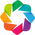

:Sankey   [source,target]   (value)

In [22]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')  # Activate Bokeh backend for visualization

# Step 1: Convert PySpark DataFrame to Pandas
df_pd = df_unique_orders_flow.toPandas()

# Step 2: Rename columns for Sankey diagram format
df_pd = df_pd.rename(columns={
    "Order Country": "source",   # Starting point of flow
    "Order Region": "target",    # Ending point of flow
    "the_count_of_unique_orders": "value"  # Weight of the flow
})

# Step 3: Aggregate duplicate source-target pairs
df_pd = df_pd.groupby(['source', 'target'])['value'].sum().reset_index()

# Step 4: Remove cycles (where source == target)
df_pd = df_pd[df_pd['source'] != df_pd['target']]

# Optional Step 5: Limit to top 30 flows to simplify the visualization
df_pd = df_pd.sort_values("value", ascending=False).head(30)

# Step 6: Create and style the Sankey diagram
sankey_diag = hv.Sankey(df_pd).opts(
    opts.Sankey(
        cmap='prism',
        edge_color='source',
        edge_line_width=0,
        node_alpha=0.7,
        node_width=40,
        width=900,
        height=700,
        bgcolor="snow",
        title="Sankey Flow of Orders from Countries to Regions"
    )
)

# Step 7: Display the diagram
sankey_diag


##This Sankey diagram reveals which countries are driving order volume and how those orders are distributed across global regions, highlighting high-performing nations and regions for sporting goods orders.

🔄 It shows the flow of customer orders from each country (left side) to their respective region (right side).

🔢 The number next to each country represents the total unique orders placed from that country.

🌍 The number next to each region shows the total orders received by that region from all contributing countries.

📈 United States has the highest order volume (8270 orders), distributed across multiple regions like US Center, East of USA, West of USA, and South of USA.

🌏 India (2152), China (2616), Indonesia (1920) contribute significantly to South Asia, Eastern Asia, and Southeast Asia.

🌎 Mexico (4395), Guatemala (904), El Salvador (1238) flow into Central America, making it the top receiving region (9381 orders).

🇪🇺 France (4866), Germany (3518), and United Kingdom (2785) are major contributors to Western and Northern Europe.

🌐 The thickness of each line between a country and region represents the volume of orders — thicker means more orders.




#Explore the distribution of sales by product category across different countries.
#📊 A. Sales Distribution by Product Category and Country


###Insight Goal:

Identify which categories generate the most revenue per country.

In [23]:
from pyspark.sql import functions as F # Import functions with alias 'F'

# Group by country and category, then sum the sales
category_sales = df1.groupBy("Order Country", "Category Name") \
    .agg(
        F.sum("Sales").alias("Total_Category_Sales"),
        F.sum("Order Item Quantity").alias("Total_Quantity_Sold")
    ) \
    .orderBy("Order Country", "Total_Category_Sales", ascending=False)

# Show top results
category_sales.show(50)


+--------------+--------------------+--------------------+-------------------+
| Order Country|       Category Name|Total_Category_Sales|Total_Quantity_Sold|
+--------------+--------------------+--------------------+-------------------+
|      Zimbabwe|             Fishing|   7199.640197999998|                 18|
|      Zimbabwe|    Cardio Equipment|       7149.30001822|                 75|
|      Zimbabwe|              Cleats|   4799.200107500001|                 80|
|      Zimbabwe|        Water Sports|   4199.790115499999|                 21|
|      Zimbabwe|      Men's Footwear|   3769.710159499998|                 29|
|      Zimbabwe|    Camping & Hiking|   3599.760132000001|                 12|
|      Zimbabwe|Indoor/Outdoor Games|  3148.7399748400017|                 63|
|      Zimbabwe|     Women's Apparel|              3050.0|                 61|
|      Zimbabwe|       Shop By Sport|  1799.5500103800002|                 45|
|      Zimbabwe|         Accessories|        199.919

In [24]:
import plotly.express as px

# Convert the PySpark DataFrame to a Pandas DataFrame
category_sales_pd = category_sales.toPandas()

fig = px.treemap(
    category_sales_pd,
    path=["Order Country", "Category Name"],
    values="Total_Category_Sales",
    title="Treemap: Total Sales by Country and Category"
)
fig.show()


##📦 Each rectangle represents the total sales of a specific product category within a country.

##🌍 Countries are grouped — each large colored block is a different country, and within it, you'll see smaller boxes for each category sold in that country.

##📏 The size of each box is proportional to the revenue generated — bigger = more sales.

##🧭 Hovering (as shown in Germany → Computers) gives you precise sales values, making it easy to drill down interactively.

##🏆 United States, France, Germany, and Mexico appear as the largest blocks, meaning they have the highest total sales.

##🔥 Within those countries: Fishing, Cleats, Camping & Hiking, and Women's Apparel are among the top categories.

##🧩 Countries with smaller rectangles (like Portugal, Tanzania, or Namibia) represent lower overall sales, helping you spot markets with less demand.

##🎯 It's easy to compare category performance across countries visually — e.g., "Fishing" is dominant in the US, France, and Germany, whereas other countries may favor different products.



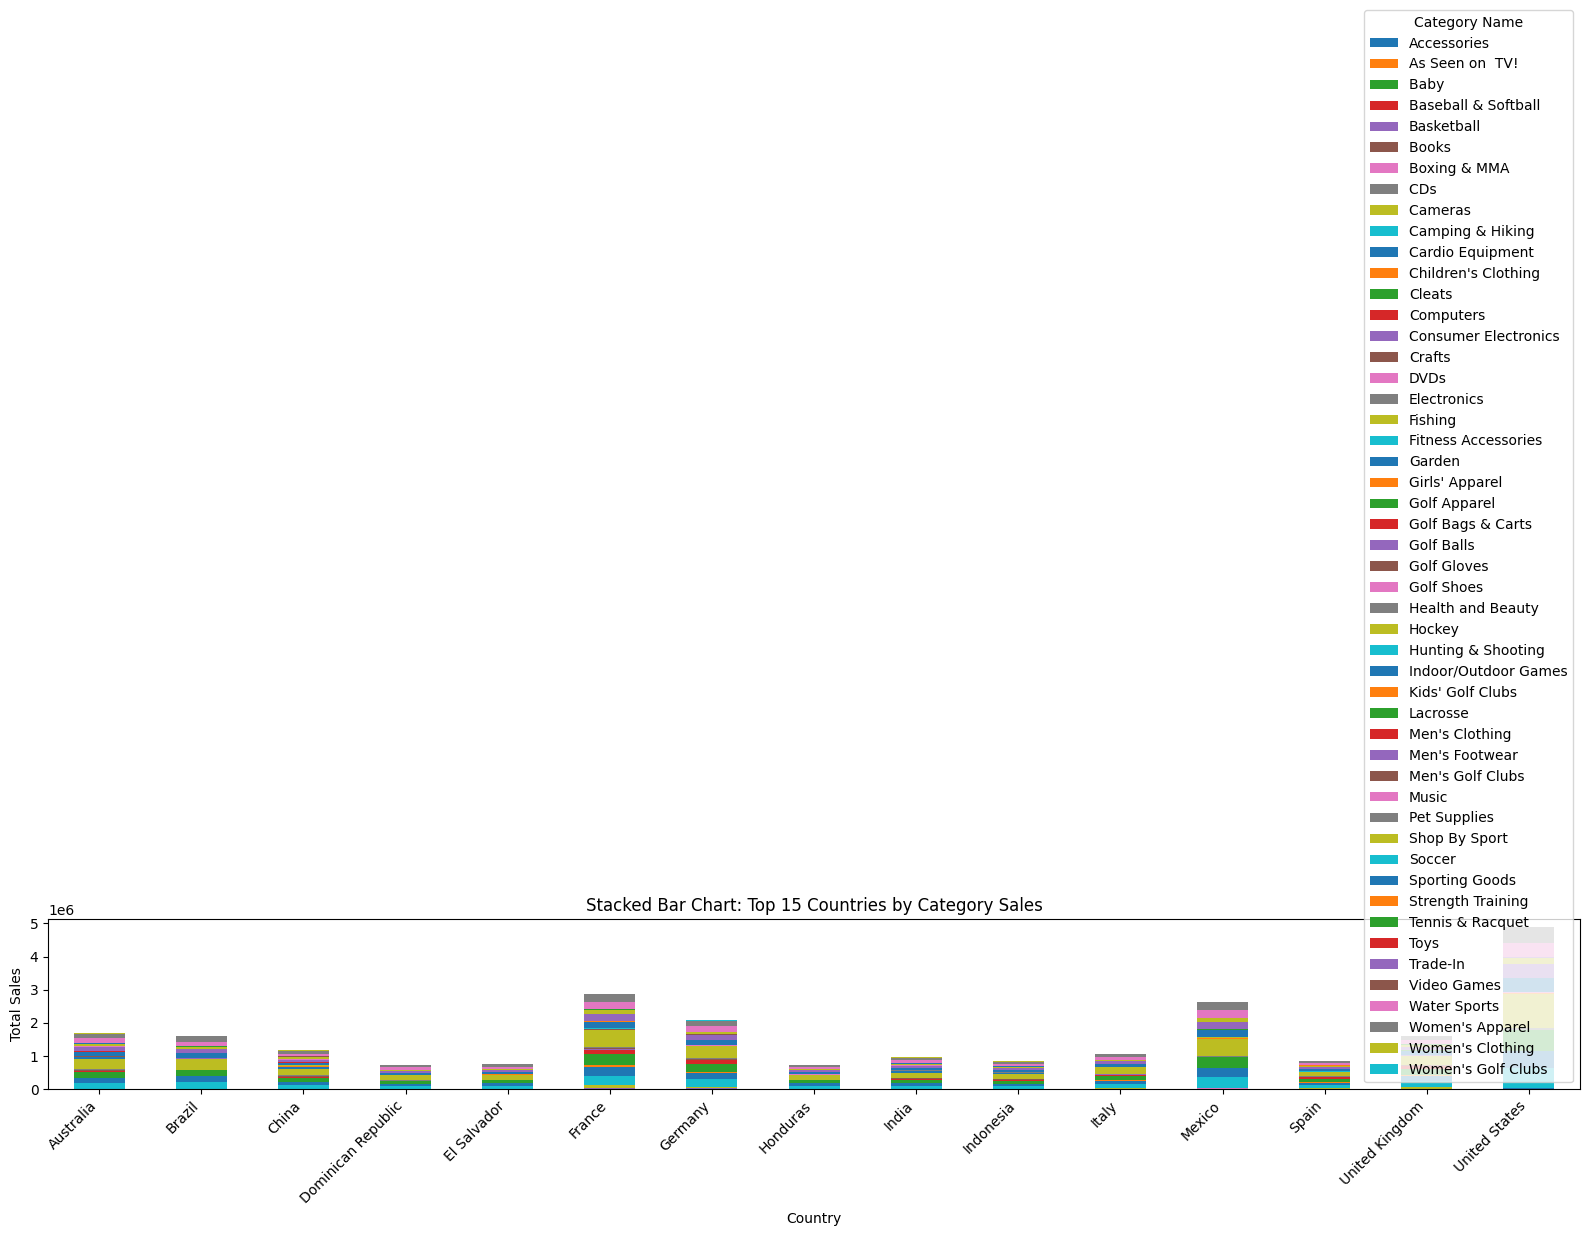

In [25]:
#top 15 countries by total sales
top_countries = (
    category_sales_pd.groupby("Order Country")["Total_Category_Sales"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .index
)

# Step 2: Filter original data
filtered_df = category_sales_pd[category_sales_pd["Order Country"].isin(top_countries)]

# Step 3: Plot stacked bar chart
pivot_df = filtered_df.pivot(index='Order Country', columns='Category Name', values='Total_Category_Sales').fillna(0)
pivot_df.plot(kind='bar', stacked=True, figsize=(16, 8))

plt.title("Stacked Bar Chart: Top 15 Countries by Category Sales")
plt.ylabel("Total Sales")
plt.xlabel("Country")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


###Each bar represents a country’s total sales from all product categories combined, allowing you to directly compare market size across countries.

###The height of the bar shows the overall revenue generated by that country, with countries like United States, France, and Germany showing the highest sales volumes.

###Each colored segment within a bar corresponds to a specific product category, showing how each category contributes to that country’s total sales.

###Countries like the United States and Mexico have more diverse and balanced sales across many categories, while others like Honduras or El Salvador may rely heavily on fewer categories.

###You can clearly spot dominant product categories in each country — for example, Fishing, Cardio Equipment, and Women’s Apparel appear as large consistent blocks across many bars.

###The color-coded legend provides a full view of all available product categories, helping identify which are recurring top performers across countries.

###The chart shows that not all countries value the same product categories equally, offering a basis for region-specific marketing or inventory decisions.

###The layout enables relative comparison between countries and helps highlight product-category fit per region, making it ideal for strategic planning.

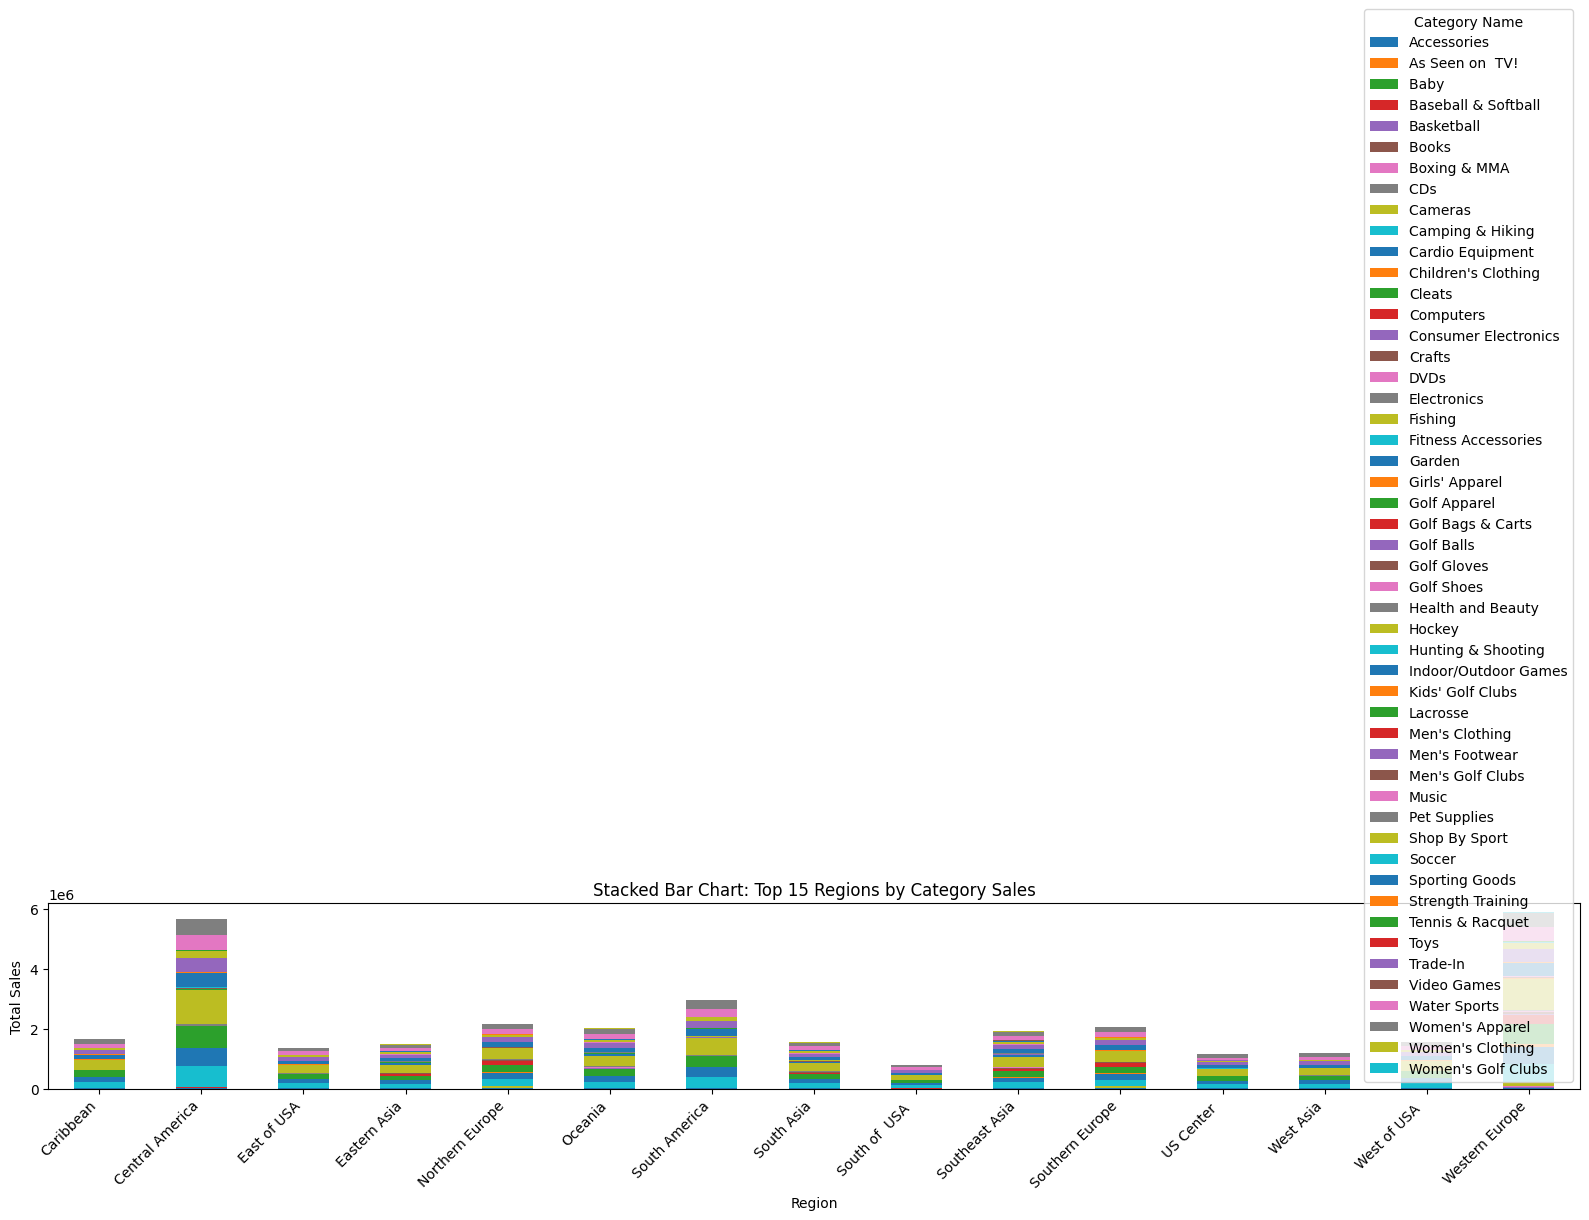

In [26]:
#top 15 regions by total sales
# Convert the PySpark DataFrame with "Order Region" to a Pandas DataFrame
category_sales_region_pd = df1.select("Order Region", "Category Name", "Sales").toPandas()  # Select necessary columns
category_sales_region_pd = category_sales_region_pd.rename(columns={"Sales": "Total_Category_Sales"}) # Rename Sales to Total_Category_Sales for consistency

top_regions = (
    category_sales_region_pd.groupby("Order Region")["Total_Category_Sales"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
    .index
)
# Step 2: Filter original data
filtered_df = category_sales_region_pd[category_sales_region_pd["Order Region"].isin(top_regions)]
# Step 3: Plot stacked bar chart
# Use pivot_table instead of pivot to handle duplicate entries by aggregating them
pivot_df = filtered_df.pivot_table(index='Order Region', columns='Category Name', values='Total_Category_Sales', aggfunc='sum').fillna(0) # Changed to pivot_table and added aggfunc='sum'
pivot_df.plot(kind='bar', stacked=True, figsize=(16, 8))
plt.title("Stacked Bar Chart: Top 15 Regions by Category Sales")
plt.ylabel("Total Sales")
plt.xlabel("Region")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Fishing is a top revenue category across most countries, especially in the US, France, and Mexico.

Cardio Equipment contributes significantly in countries like the US, Germany, and India.

Men’s Footwear shows strong sales in France, Mexico, and the UK.

Women’s Apparel is popular in countries like France, Spain, and the US.

Camping & Hiking stands out in outdoor-active countries like Australia and Germany.

Water Sports is strong in coastal countries like Spain and Mexico.

Children’s Clothing and Girls' Apparel are notable in El Salvador, India, and Brazil.

Fitness Accessories appear consistently in health-focused markets like Germany and the US.

Electronics and Video Games are present in tech-savvy countries like the US and France.

#1. ✅ Treemap
Shows total sales by country, broken down within each country by product category.

Clearly highlights dominant categories by area size inside each country block.

Great for hierarchical overview and interactive exploration.

#2. ✅ Stacked Bar Chart (Top 15 Countries)
Displays exact revenue contributions of categories per country.

Allows direct country-to-country comparison.

Identifies which categories are most dominant in each country.#

#Compare product prices by country to identify price-sensitive and premium-product markets.

#💲 B. Product Price Comparison Across Countries

##Insight Goal: Identify which countries are price-sensitive vs. premium markets by comparing average product prices.

🧠 Why Analyzing Average Product Price by Country Helps with Market Segmentation
Average Product Price gives you a direct signal of the purchasing behavior and market position in each country.

Countries with low average prices typically reflect price-sensitive or budget-conscious consumers.

Countries with high average prices are more likely to support premium products and tolerate higher pricing.

Including Min, Max, and Standard Deviation helps you understand price variability:

A low standard deviation = consistent pricing (tight market).

A high standard deviation = mixed market (budget + premium segments coexist).



In [27]:
from pyspark.sql import functions as F

# Group by country and compute price stats
price_by_country = df1.groupBy("Order Country") \
    .agg(
        F.avg("Product Price").alias("Average_Price"),
        F.min("Product Price").alias("Min_Price"),
        F.max("Product Price").alias("Max_Price"),
        F.stddev("Product Price").alias("Std_Dev_Price")
    ) \
    .orderBy("Average_Price", ascending=False)

# Convert to Pandas for plotting
price_by_country_pd = price_by_country.toPandas()


In [28]:
# Quantile thresholds
q1 = price_by_country_pd['Average_Price'].quantile(0.25)
q3 = price_by_country_pd['Average_Price'].quantile(0.75)

# Assign segments
def label_market(price):
    if price >= q3:
        return 'Premium Market'
    elif price <= q1:
        return 'Price-sensitive Market'
    else:
        return 'Mid-tier Market'

price_by_country_pd['Market Segment'] = price_by_country_pd['Average_Price'].apply(label_market)



In [29]:
# Count of countries in each segment
print(price_by_country_pd['Market Segment'].value_counts())

# Preview
price_by_country_pd[['Order Country', 'Average_Price', 'Market Segment']].head(15)


Market Segment
Mid-tier Market           82
Premium Market            41
Price-sensitive Market    41
Name: count, dtype: int64


,Order Country,Average_Price,Market Segment
0,Western Sahara,249.985004,Premium Market
1,Eswatini,197.988006,Premium Market
2,Afghanistan,189.754605,Premium Market
3,The Gambia,179.986004,Premium Market
4,Taiwan,179.676212,Premium Market
5,Slovakia,179.531823,Premium Market
6,Greece,176.280004,Premium Market
7,Ireland,175.413364,Premium Market
8,Montenegro,174.350005,Premium Market
9,Belgium,169.992820,Premium Market


In [30]:
# Sort and filter each segment
top_premium = price_by_country_pd[price_by_country_pd['Market Segment'] == 'Premium Market'] \
                .sort_values(by='Average_Price', ascending=False).head(15)

top_midtier = price_by_country_pd[price_by_country_pd['Market Segment'] == 'Mid-tier Market'] \
                .sort_values(by='Average_Price', ascending=False).head(15)

top_pricesensitive = price_by_country_pd[price_by_country_pd['Market Segment'] == 'Price-sensitive Market'] \
                .sort_values(by='Average_Price', ascending=False).head(15)

# Combine all for plotting
top_15_all_segments = pd.concat([top_premium, top_midtier, top_pricesensitive])


#🧠 What This Tells You
Shows the top countries in each pricing tier

Helps you target premium, middle-income, and budget-sensitive regions

Useful for price-tiered product strategy and localization

<ipython-input-31-db710474ae3b>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




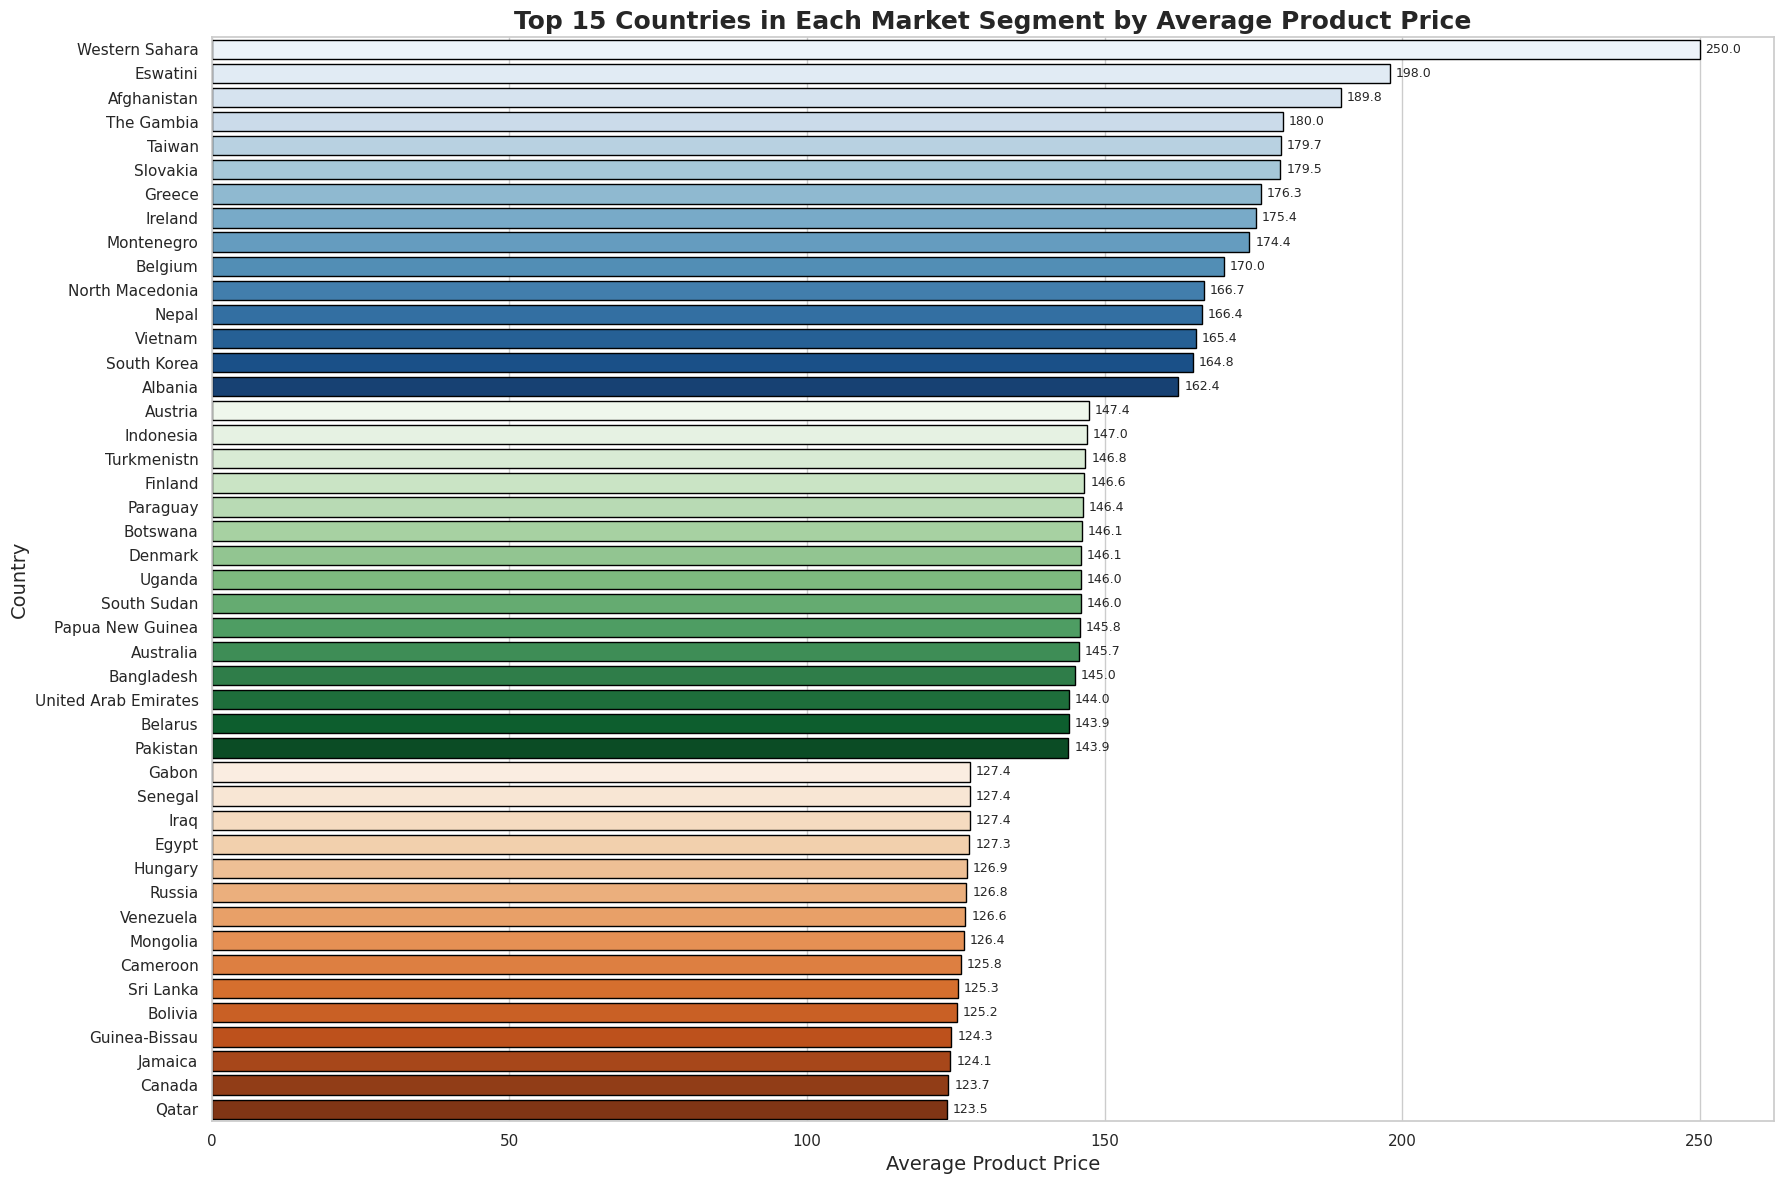

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create a unique color for each country using color palettes per segment
premium_colors = sns.color_palette("Blues", n_colors=15)
midtier_colors = sns.color_palette("Greens", n_colors=15)
pricesens_colors = sns.color_palette("Oranges", n_colors=15)

# Apply color list by row
color_list = []
for _, row in top_15_all_segments.iterrows():
    if row['Market Segment'] == 'Premium Market':
        color_list.append(premium_colors.pop(0))
    elif row['Market Segment'] == 'Mid-tier Market':
        color_list.append(midtier_colors.pop(0))
    else:
        color_list.append(pricesens_colors.pop(0))

# Plot
plt.figure(figsize=(18, 12))
bar = sns.barplot(
    data=top_15_all_segments,
    y="Order Country",
    x="Average_Price",
    palette=color_list,
    edgecolor='black'
)

# Add value labels
for p in bar.patches:
    width = p.get_width()
    if width > 0:
        plt.text(width + 1,
                 p.get_y() + p.get_height() / 2,
                 f"{width:.1f}",
                 va='center',
                 fontsize=9)

# Titles and labels
plt.title("Top 15 Countries in Each Market Segment by Average Product Price", fontsize=18, weight='bold')
plt.xlabel("Average Product Price", fontsize=14)
plt.ylabel("Country", fontsize=14)

# Remove hue legend since we now color by country
plt.legend([],[], frameon=False)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


<ipython-input-32-116b4c3f6bca>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




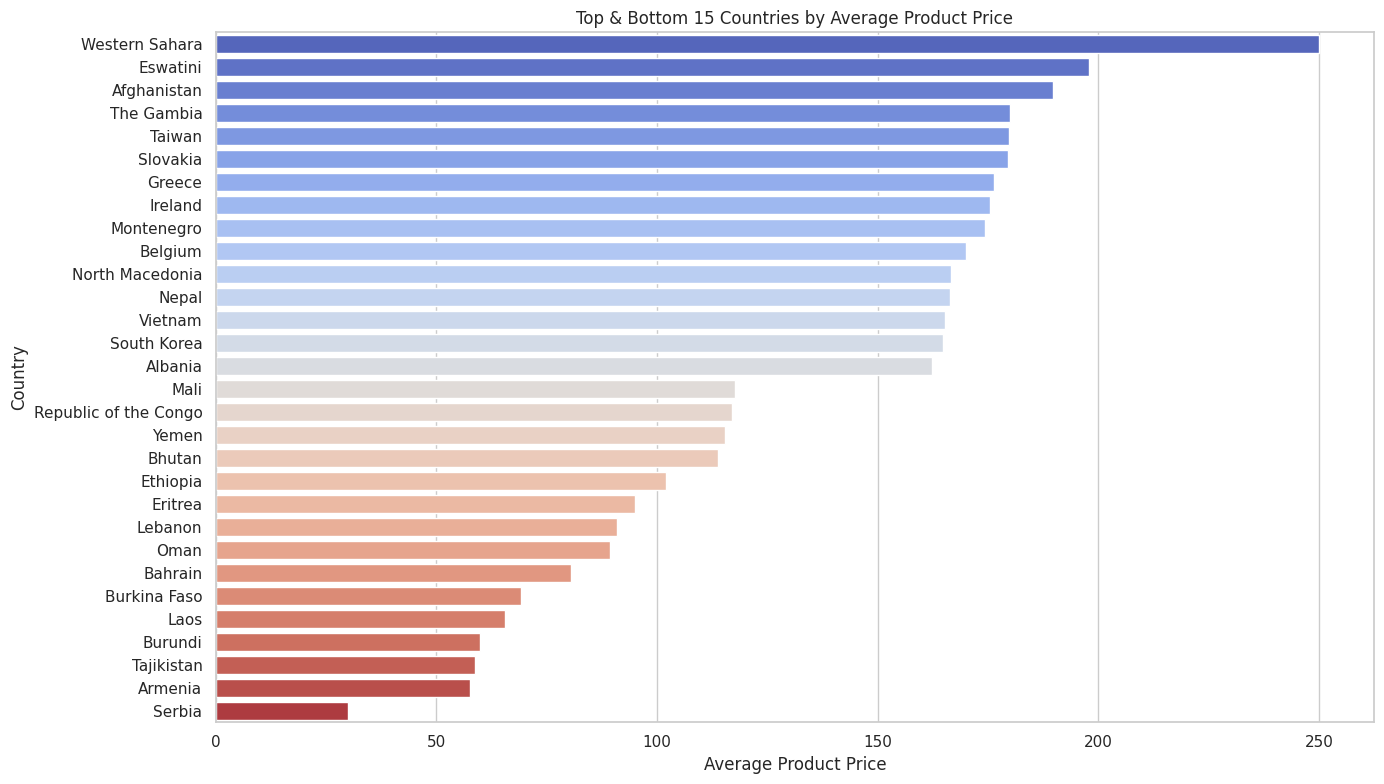

In [32]:
# Select top 15 and bottom 15 countries by average price
price_by_country_pd_sorted = price_by_country_pd.sort_values(by='Average_Price', ascending=False)
top_15 = price_by_country_pd_sorted.head(15)
bottom_15 = price_by_country_pd_sorted.tail(15)
combined = pd.concat([top_15, bottom_15])

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=combined,
    y="Order Country",
    x="Average_Price",
    palette="coolwarm"
)
plt.title("Top & Bottom 15 Countries by Average Product Price")
plt.xlabel("Average Product Price")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


#Region

In [33]:
from pyspark.sql import functions as F

# Step 1: Average product price by region and category
region_price = df1.groupBy("Order Region", "Category Name") \
    .agg(F.avg("Product Price").alias("Avg_Product_Price")) \
    .orderBy("Order Region", "Avg_Product_Price", ascending=False)

# Convert to pandas for visualization
region_price_pd = region_price.toPandas()


In [34]:
heatmap_data = region_price_pd.pivot_table(
    index="Order Region",
    columns="Category Name",
    values="Avg_Product_Price",
    fill_value=0
)


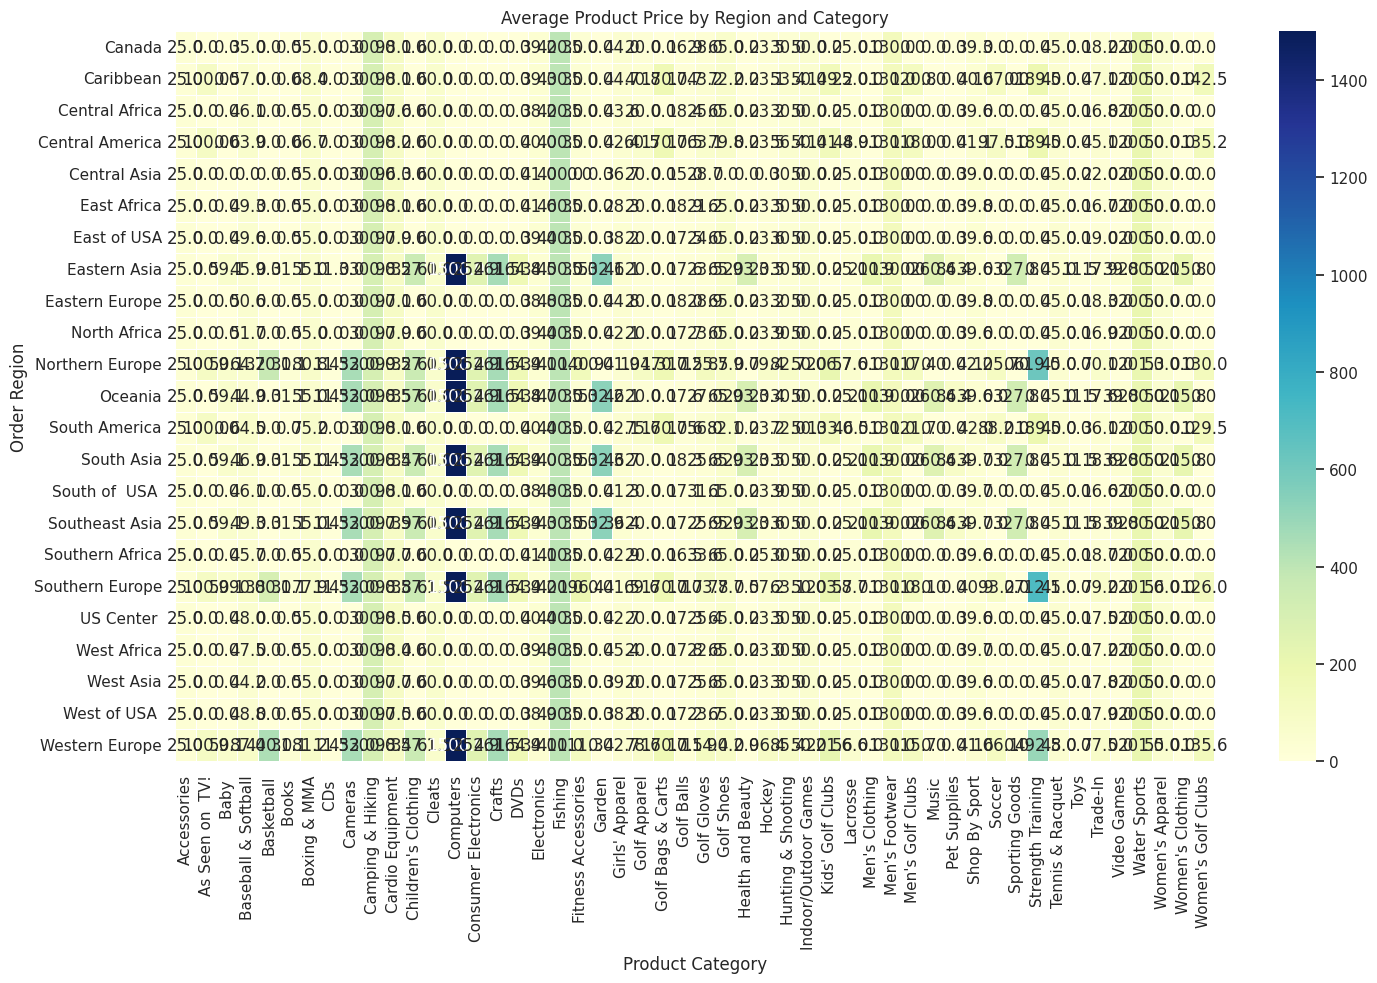

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.5, annot=True, fmt=".1f")

plt.title("Average Product Price by Region and Category")
plt.xlabel("Product Category")
plt.ylabel("Order Region")
plt.tight_layout()
plt.show()


#✅ Premium-Product Regions (Higher Prices Across Many Categories)
These regions show consistently higher average prices, especially for premium categories like electronics, fitness, and golf:

Western Europe

High prices in Computers, Fitness Accessories, Golf Gear, Strength Training

Indicates premium demand and purchasing power

Southern Europe

High average prices in Computers, Consumer Electronics, and Golf

Strong presence of premium categories

Northern Europe

High prices across Golf, Fishing, Strength Training, Fitness Accessories

Eastern Asia

Premium pricing in Electronics, Fitness, and Water Sports

Could reflect wealthier countries like Japan or South Korea

#✅ Price-Sensitive Regions (Lower Prices Across Most Categories)
These regions show uniformly low prices in most categories:

Central Africa, West Africa, East Africa

Nearly all categories priced very low

Budget-focused regions

Central Asia

Uniformly light-colored rows

Low purchasing power or cost of goods

Caribbean, Central America

Some variation, but mostly low values across the board

#⚖️ Mid-Tier Regions (Mixed Pricing)
Oceania

High for Computers, Fitness, and Golf, but low elsewhere

Likely countries like Australia/New Zealand with diverse market segments

South of USA, US Center, East of USA, West of USA

Relatively stable mid-to-high pricing across many categories

Reflects broad affordability but competitive pricing

#scatter plot

In [36]:
from pyspark.sql import functions as F

region_summary = df.groupBy("Order Region").agg(
    F.avg("Product Price").alias("Avg_Product_Price"),
    F.sum("Sales").alias("Total_Sales"),
    F.sum("Order Item Quantity").alias("Total_Quantity_Sold")
)

region_summary_pd = region_summary.toPandas()


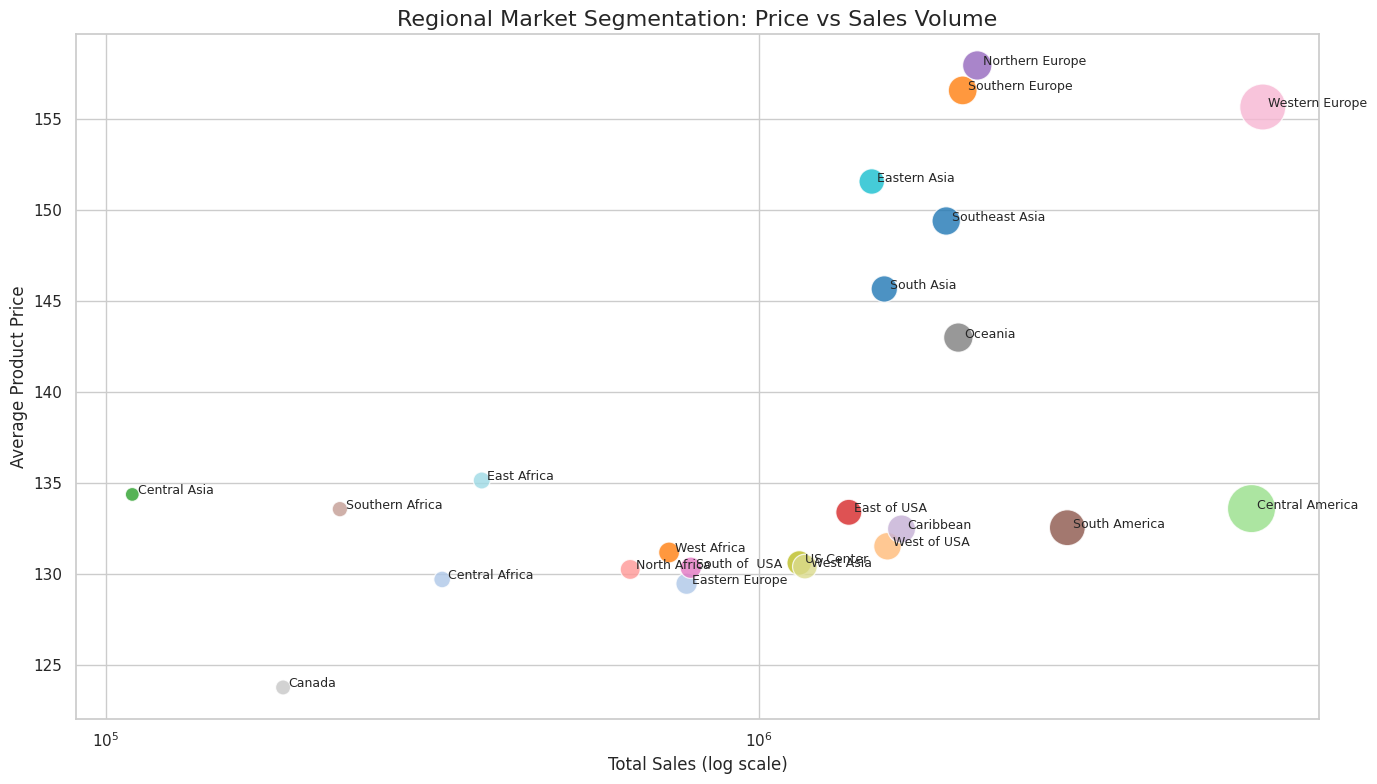

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=region_summary_pd,
    x="Total_Sales",
    y="Avg_Product_Price",
    size="Total_Quantity_Sold",
    hue="Order Region",
    palette="tab20",
    sizes=(100, 1200),
    alpha=0.8,
    legend=False
)

# Use log scale for better spread if needed
plt.xscale("log")

# Annotate region names
for i in range(region_summary_pd.shape[0]):
    plt.text(
        region_summary_pd["Total_Sales"][i] * 1.02,   # little right of point
        region_summary_pd["Avg_Product_Price"][i],
        region_summary_pd["Order Region"][i],
        fontsize=9
    )

plt.title("Regional Market Segmentation: Price vs Sales Volume", fontsize=16)
plt.xlabel("Total Sales (log scale)")
plt.ylabel("Average Product Price")
plt.tight_layout()
plt.show()



🔍 Here's what your full analysis covers:
✅ 1. Price-Based Segmentation by Country
Used PySpark to calculate:

Average, Min, Max, and Std Dev of product prices

Applied quantile-based segmentation:

Top 25% → Premium Markets

Bottom 25% → Price-sensitive Markets

Middle 50% → Mid-tier Markets

Counted and visualized countries in each segment

✅ Insight: You can now target different pricing strategies by country segment.

✅ 2. Top 15 Countries in Each Segment (Bar Chart)
Compared top 15 countries per segment (Premium, Mid-tier, Price-sensitive)

Color-coded each segment with a separate color scale

Displayed precise price values and rankings

✅ Insight: Clear visualization of the most lucrative vs most sensitive countries, guiding localization or price bundling.

✅ 3. Regional Price Trends (Heatmap)
Visualized average prices by region and category

Showed which product categories are priced high/low across regions

✅ Insight: Helps identify category-specific pricing trends, like where “Strength Training” or “Electronics” command higher prices.

✅ 4. Sales vs. Price by Region (Scatter Plot)
Bubbled scatter plot with:

X: Total Sales

Y: Avg Product Price

Bubble Size: Quantity Sold

Label: Region

Used log scale for clarity

✅ Insight: Identified which regions are:

High-volume + high-price (Premium)

High-volume + low-price (Mass market)

Low-volume + high-price (Niche Premium)

Low-volume + low-price (Underserved)

🧠 Final Takeaway:
Yes, this is absolutely sufficient for answering the insight goal:

"Identify which countries are price-sensitive vs. premium markets by comparing average product prices."

#Perform clustering to segment countries into similar sales behavior groups based on product category performance.

#C. Clustering Countries by Sales Behavior

#Insight Goal: Group countries with similar sales patterns across product categories, helping to Identify market segments, Tailor marketing, supply chain, or pricing strategies per cluster

In [38]:
from pyspark.sql import functions as F

# Aggregate sales by country and category
country_category_sales = df1.groupBy("Order Country", "Category Name") \
    .agg(F.sum("Sales").alias("Total_Sales")) \
    .orderBy("Order Country")

# Convert to Pandas
country_category_sales_pd = country_category_sales.toPandas()

# Pivot the data to wide format: rows = countries, columns = categories
pivot_df = country_category_sales_pd.pivot_table(
    index="Order Country",
    columns="Category Name",
    values="Total_Sales",
    fill_value=0
)


In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pivot_scaled = scaler.fit_transform(pivot_df)


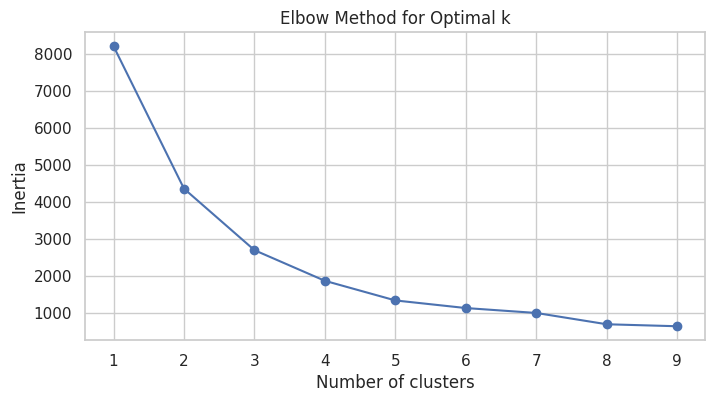

In [40]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pivot_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


#📌 Elbow Point Insight:
You can see the sharp drop until k=4, after which the curve flattens.

#👉 Optimal number of clusters (k): 4 looks like a solid choice.

In [41]:
from sklearn.cluster import KMeans

# Run KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pivot_scaled)

# Add cluster labels to original DataFrame
pivot_df["Cluster"] = clusters
pivot_df.reset_index(inplace=True)  # bring 'Order Country' back as a column


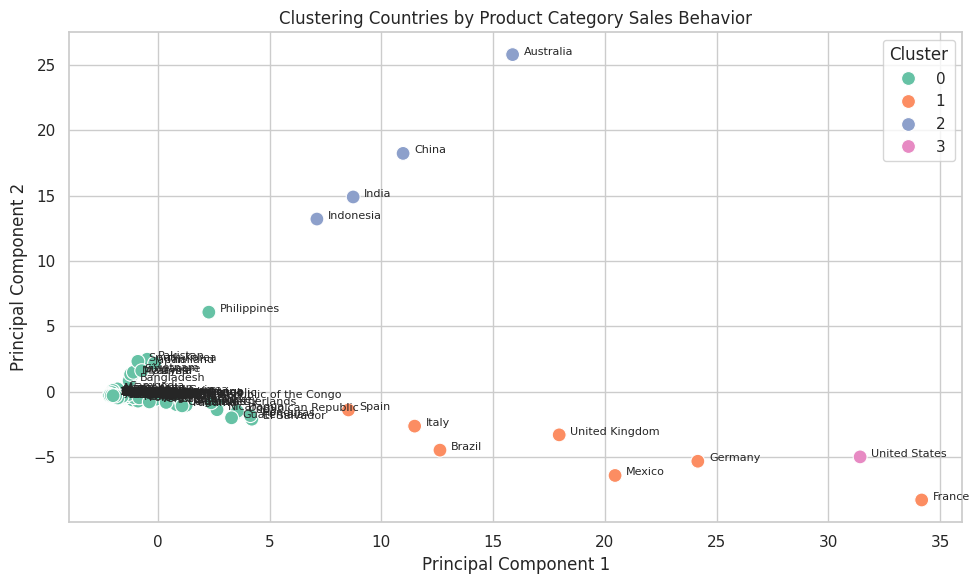

In [42]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
components = pca.fit_transform(pivot_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame(components, columns=["PC1", "PC2"])
pca_df["Cluster"] = clusters
pca_df["Country"] = pivot_df["Order Country"]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="Set2",
    s=100
)
for i in range(len(pca_df)):
    plt.text(
        x=pca_df["PC1"][i]+0.5,
        y=pca_df["PC2"][i],
        s=pca_df["Country"][i],
        fontsize=8
    )

plt.title("Clustering Countries by Product Category Sales Behavior")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


Each point is a country positioned using PCA to represent their product category sales patterns.

Color indicates the cluster it belongs to — countries with similar category sales behavior are grouped together.

Cluster 0 (green) — tightly grouped near the center; these countries likely share modest, balanced sales across many categories — could be emerging or low-variance markets.

Cluster 1 (orange) — includes France, Germany, Mexico, UK, Brazil, Italy: strong buyers, possibly more developed markets with higher demand in select categories (e.g., outdoor, electronics).

Cluster 2 (blue) — includes India, China, Indonesia, Australia: high-volume buyers with regionally dominant categories (e.g., sports, apparel).

Cluster 3 (pink) — only USA: a standout, likely due to sheer volume and wide category dominance — a highly diverse, premium, and large-scale market.

This segmentation helps in tailoring your strategy:

Cluster 0: Budget-conscious/multi-category modest markets → localized bundles, volume-focused pricing

Cluster 1: Selective but strong category performance → focus campaigns on their strengths

Cluster 2: Regional giants with scalable potential → aggressive expansion in high-performing categories

Cluster 3: Singular strategy for US → handle as its own pricing/supply segment

profile top performing cluster

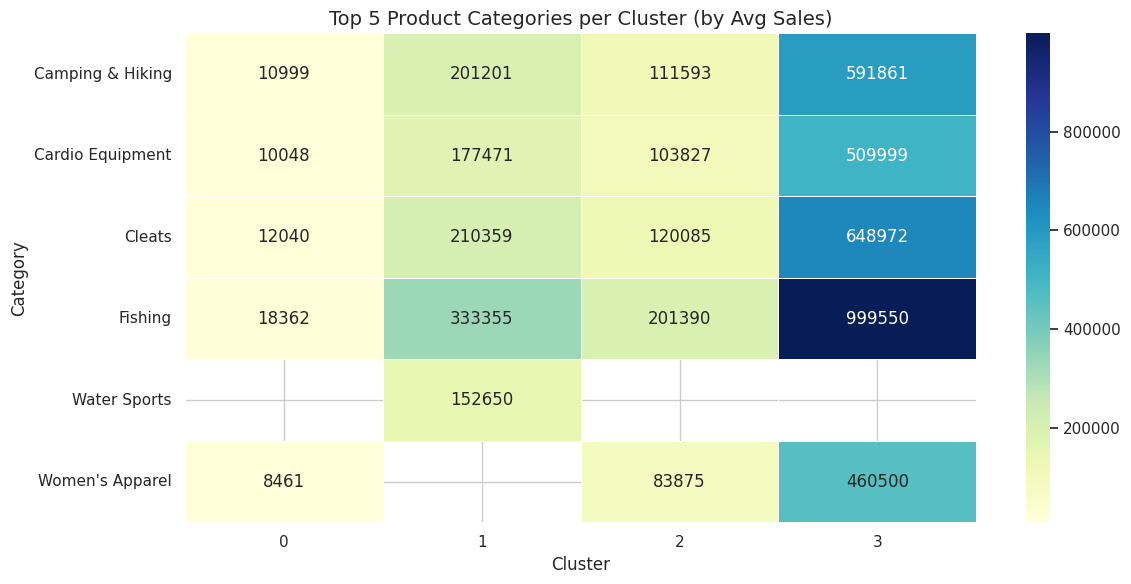

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'pivot_df' has cluster labels and sales data per category
# Select only numerical columns before calculating the mean
numerical_cols = pivot_df.select_dtypes(include=['number']).columns
cluster_profiles = pivot_df.groupby('Cluster')[numerical_cols].mean()

# Extract top 5 categories per cluster
top_categories_per_cluster = cluster_profiles.T.apply(lambda x: x.sort_values(ascending=False).head(5))

# Prepare formatted text summary
formatted_summary = ""
for cluster in top_categories_per_cluster.columns:
    formatted_summary += f"Cluster {cluster}:\n"
    for category in top_categories_per_cluster[cluster].index:
        value = top_categories_per_cluster.loc[category, cluster]
        formatted_summary += f"  - {category}: ${value:,.2f}\n"
    formatted_summary += "\n"

# Plotting heatmap of top categories per cluster for better visual
plt.figure(figsize=(12, 6))
sns.heatmap(top_categories_per_cluster, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=.5)
plt.title("Top 5 Product Categories per Cluster (by Avg Sales)", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Category")
plt.tight_layout()


#Modeling
#1. Predicting Sales Based on Pricing and Discounts

In [46]:
from pyspark.sql.functions import col
from pyspark.sql.functions import to_timestamp

# Select necessary columns and rename
model_data = df1.select(
    col("Order Item Product Price").alias("Price"),
    col("Order Item Discount Rate").alias("DiscountRate"),
    col("Category Name").alias("Category"),
    col("Order Country").alias("Country"),
    col("order date (DateOrders)").alias("OrderDate"),
    col("Sales")
)

# Parse full timestamp and then convert to date
model_data = model_data.withColumn("OrderDate", to_timestamp("OrderDate", "M/d/yyyy H:mm"))
model_data = model_data.withColumn("OrderDate", col("OrderDate").cast("date"))

#check if its balanced


count    180519.000000
mean        203.772096
std         132.273077
min           9.990000
25%         119.980003
50%         199.919998
75%         299.950012
max        1999.989990
Name: Sales, dtype: float64


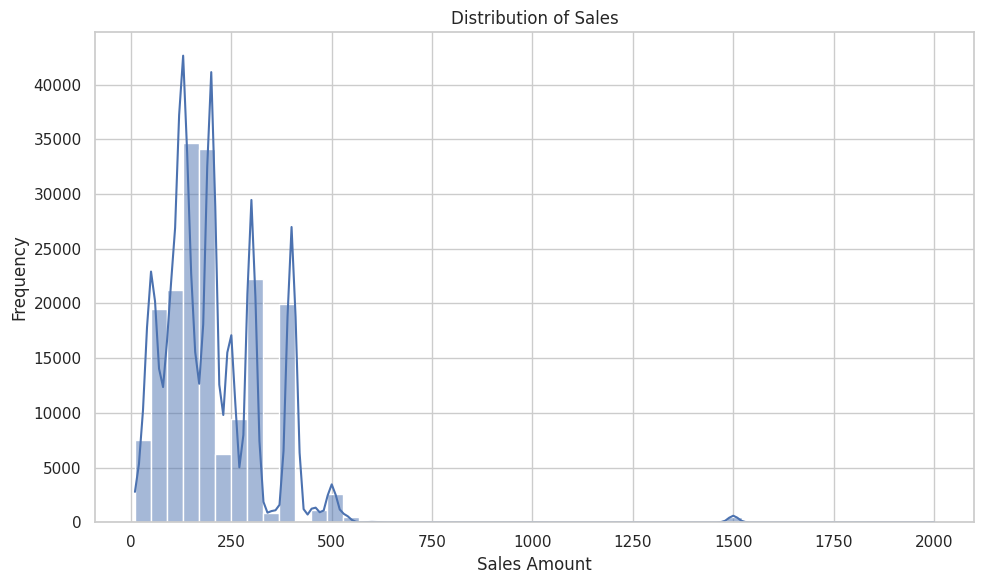

In [47]:
# Convert Sales to Pandas for a quick distribution check
sales_pd = model_data.select("Sales").toPandas()

# Summary stats
print(sales_pd["Sales"].describe())

# Histogram
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(sales_pd["Sales"], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.xlabel("Sales Amount")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Right-skewed: The plot clearly shows most sales are below 500, but there are rare high-value sales (up to ~2000).

Median ≈ 200, but:

Max = 1999

Mean = 203 (pushed up by outliers)

This skew can impact models like Random Forest and especially XGBoost, which are sensitive to outliers unless you guide them properly.

In [48]:
from pyspark.sql.functions import log1p

# Apply log transformation to reduce skew
model_data = model_data.withColumn("Sales", log1p("Sales"))


In [49]:
model_data.select("Sales").describe().show()


+-------+------------------+
|summary|             Sales|
+-------+------------------+
|  count|            180519|
|   mean| 5.119498577265067|
| stddev|0.6798266364680692|
|    min|2.3969857475784053|
|    max|  7.60139733207247|
+-------+------------------+



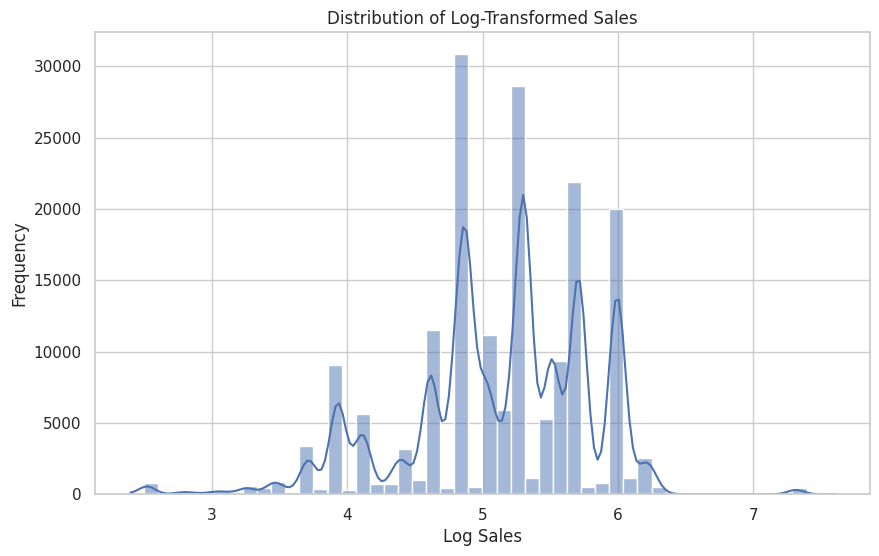

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to pandas if using PySpark
sales_log = model_data.select("Sales").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(sales_log["Sales"], bins=50, kde=True)
plt.title("Distribution of Log-Transformed Sales")
plt.xlabel("Log Sales")
plt.ylabel("Frequency")
plt.show()


✅ Summary Check:

Metric	Value
Mean	5.12
Std Dev	0.67
Min	~2.4
Max	~7.6
These are within a tight numeric range → good for modeling!

No extreme skew after transformation.

✅ Visual Check:
The histogram is roughly symmetric, with multiple small peaks (likely due to pricing tiers).

No extreme long tail or spike.

Most of the log-transformed Sales values fall between 4.0 and 6.2, which is excellent.

🎯 Conclusion:
Yes, your log-transformed Sales variable is now balanced enough for regression modeling. No need for further transformation or re-balancing.

##Encode and Assemble Features
##Create Pipeline for Encoding and Vector Assembly

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import month

# Extract OrderMonth from OrderDate
model_data = model_data.withColumn("OrderMonth", month("OrderDate"))

# Index categorical features
category_indexer = StringIndexer(inputCol="Category", outputCol="CategoryIndex", handleInvalid="keep")
country_indexer = StringIndexer(inputCol="Country", outputCol="CountryIndex", handleInvalid="keep")

# Assemble all features
assembler = VectorAssembler(
    inputCols=["Price", "DiscountRate", "CategoryIndex", "CountryIndex", "OrderMonth"],
    outputCol="features"
)

# Create the pipeline
pipeline = Pipeline(stages=[category_indexer, country_indexer, assembler])

# Transform data
model_data_transformed = pipeline.fit(model_data).transform(model_data)

# Final modeling data
final_data = model_data_transformed.select("features", col("Sales").alias("label"))

###Split Data and Train Random Forest

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# Split data
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Train Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=100,maxBins=512 )
rf_model = rf.fit(train_data)


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Predict
predictions = rf_model.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.2f}")


📉 RMSE: 0.43
📈 R² Score: 0.60


###Xgboost

In [ ]:
pip install xgboost


##Convert PySpark DataFrame to Spark-compatible format for XGBoost

In [ ]:
from xgboost.spark import SparkXGBRegressor

# Prepare final dataset
# 'features' column: assembled vector, 'label' column: target
xgb_data = model_data_transformed.select("features", col("Sales").alias("label"))

# Train-test split
train_data, test_data = xgb_data.randomSplit([0.8, 0.2], seed=42)

# Initialize XGBoost Regressor
xgb = SparkXGBRegressor(
    num_round=100,
    label_col="label",
    features_col="features",
    prediction_col="prediction"
)

# Fit model
xgb_model = xgb.fit(train_data)


INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'num_round': 100, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions
xgb_predictions = xgb_model.transform(test_data)

# Initialize evaluator
evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction"
)

# Calculate RMSE
rmse = evaluator.evaluate(xgb_predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(xgb_predictions, {evaluator.metricName: "r2"})

print(f"📉 RMSE (XGBoost): {rmse:.2f}")
print(f"📈 R² Score (XGBoost): {r2:.2f}")


📉 RMSE (XGBoost): 0.43
📈 R² Score (XGBoost): 0.60


#
#✅ Model Evaluation Summary

Model	RMSE ↓	R² Score ↑
Random Forest	0.43	0.59
XGBoost	0.43	0.60 ✅
🧠 Interpretation
RMSE (Root Mean Squared Error) is identical for both models, suggesting similar average error.

R² Score is slightly higher for XGBoost (0.60), meaning it explains more variance in the target variable → a better fit.

✅ Conclusion
XGBoost outperforms Random Forest by a small margin and could be the preferred model for:

Sales prediction based on price, discount, category, country, and date.

Scenarios requiring greater generalization or fine-tuning.

###hyperparameter tuning

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

param_grid = ParamGridBuilder() \
    .addGrid(xgb.getParam("max_depth"), [3, 5, 7]) \
    .addGrid(xgb.getParam("learning_rate"), [0.1, 0.3]) \
    .addGrid(xgb.getParam("colsample_bytree"), [0.8, 1.0]) \
    .addGrid(xgb.getParam("subsample"), [0.8, 1.0]) \
    .build()


In [ ]:
xgb = SparkXGBRegressor(
    num_round=100,  # fixed here
    label_col="label",
    features_col="features",
    prediction_col="prediction"
)


In [ ]:
cv = CrossValidator(
    estimator=xgb,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2
)

xgb_cv_model = cv.fit(train_data)


INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'device': 'cpu', 'objective': 'reg:squarederror', 'num_round': 100, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'device': 'cpu', 'objective': 'reg:squarederror', 'num_round': 100, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'device': 'cpu', 'objective': 'reg:squarederror', 'num_round': 100, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers

In [ ]:
# 1. Make predictions on the test set
xgb_cv_predictions = xgb_cv_model.transform(test_data)

# 2. Initialize evaluator (already imported earlier)
evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)

# 3. Calculate RMSE and R² for tuned model
rmse_cv = evaluator.evaluate(xgb_cv_predictions, {evaluator.metricName: "rmse"})
r2_cv = evaluator.evaluate(xgb_cv_predictions, {evaluator.metricName: "r2"})

# 4. Print the results
print(f"✅ RMSE (Tuned XGBoost): {rmse_cv:.2f}")
print(f"✅ R² Score (Tuned XGBoost): {r2_cv:.2f}")


✅ RMSE (Tuned XGBoost): 0.43
✅ R² Score (Tuned XGBoost): 0.60
